In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import config
import utility.io
import utility.plotlib

#env = sys.argv[1] if len(sys.argv) > 2 else "dev"

In [2]:
# Setup configuration
cfg = config.ResearchConfig
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT

# Retrieve data
df_subspt, df_lesson = utility.io.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

Complete loading data for subscription and lesson history!


# Distribution of subscription length per pupil

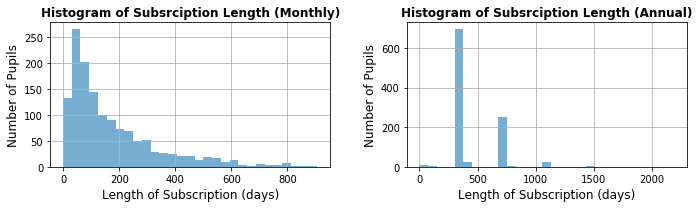

In [3]:
# Distribution of subscription length per pupil

utility.plotlib.subscpt_dist(df_subspt, cfg)

# Active subscriptions over time
x - Date
<br> y - Number of active subscriptions
# Average remaining subscription length
x - Date
<br> y - Average subscription time length left per student

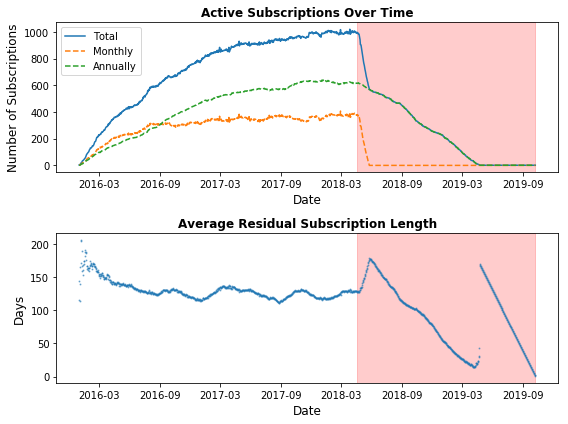

In [69]:
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=date_format)

last_date = df_subspt.subscription_end_date.max()
first_date = df_subspt.subscription_start_date.min()

dates = list(pd.date_range(start=first_date, end=last_date, freq='D'))
num_subspt = np.zeros(len(dates))
num_subspt_monthly = np.zeros(len(dates))
num_subspt_annually = np.zeros(len(dates))
res_subspt_length = np.zeros(len(dates))
#dates = dates[0:len(dates)-1]

temp = df_subspt.groupby(['subscription_start_date', 'subscription_length']).count()
for row in temp.itertuples(index=True):
    start_date, length = row.Index
    i_start = dates.index(start_date)
    
    # Number of subscriptions
    if length > 31:
        num_subspt_annually[i_start : i_start+length+1] = \
        num_subspt_annually[i_start : i_start+length+1] + 1*row.subscription_type
    else:
        num_subspt_monthly[i_start : i_start+length+1] = \
        num_subspt_monthly[i_start : i_start+length+1] + 1*row.subscription_type
    # Residual subscrption length
    res_subspt_length[i_start : i_start+length+1] = \
    res_subspt_length[i_start : i_start+length+1] + np.arange(length+1,0,-1)*row.subscription_type

num_subspt = num_subspt_monthly + num_subspt_annually
res_subspt_length = res_subspt_length / num_subspt
df_subspt_overtime = pd.DataFrame({'num_subscriptions': num_subspt,
                                  'num_subscriptions_monthly': num_subspt_monthly,
                                  'num_subscriptions_annually': num_subspt_annually,
                                  'res_subscriptions_length': res_subspt_length}, index=dates)

# We can also have the data in different frequencies, like monthly
# df_subspt_overtime_monthly = df_subspt_overtime.resample('M').sum()

# Active subscriptions over time
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(211)
ax.plot(df_subspt_overtime.index, df_subspt_overtime.num_subscriptions, label='Total')
ax.plot(df_subspt_overtime.index, df_subspt_overtime.num_subscriptions_monthly, '--', label='Monthly')
ax.plot(df_subspt_overtime.index, df_subspt_overtime.num_subscriptions_annually, '--', label='Annually')
ax.axvspan(cutoff_date, last_date, color='red', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Subscriptions')
ax.set_title('Active Subscriptions Over Time')
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.title.set_fontsize(12)
ax.title.set_fontweight('bold')
ax.legend()

# Average remaining subscription length
ax = fig.add_subplot(212)
ax.plot(df_subspt_overtime.index, df_subspt_overtime.res_subscriptions_length, 'o', markersize=1, alpha=0.5)
ax.axvspan(cutoff_date, last_date, color='red', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Days')
ax.set_title('Average Residual Subscription Length')
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.title.set_fontsize(12)
ax.title.set_fontweight('bold')

plt.tight_layout()
plt.show()

In [30]:
# Cancellation and renewal counts over time
# Cancellation, renewal, resubscription
# Monthly/Annually/Total renewal
# M --> A renewal
# A --> M renewal

cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=date_format)
renewal_gap = pd.to_timedelta(cfg.RENEWAL_GAP, unit='D')

# Keep subscriptions with end date at least n days earlier than the cutoff date, where n is the allowed renewal_gap
cutoff_date = cutoff_date - renewal_gap
df = df_subspt[df_subspt.subscription_end_date<=cutoff_date]


In [31]:
last_date = df.subscription_end_date.max()
first_date = df.subscription_start_date.min()
dates = list(pd.date_range(start=first_date, end=last_date, freq='D'))

num_ccl_mon = np.zeros(len(dates)) # Number of cancellations from existing monthly subscription
num_ccl_ann = np.zeros(len(dates)) # Number of cancellations from existing annually subscription
num_rnl_m2m = np.zeros(len(dates)) # Number of renewals from monthly to monthly subscription 
num_rnl_m2a = np.zeros(len(dates)) # Number of renewals from monthly to annually subscription
num_rnl_a2m = np.zeros(len(dates)) # Number of renewals from annually to monthly subscription
num_rnl_a2a = np.zeros(len(dates)) # Number of renewals from annually to annually subscription
num_rsc_m2m = np.zeros(len(dates)) # Number of re-subscriptions from monthly to monthly subscription 
num_rsc_m2a = np.zeros(len(dates)) # Number of re-subscriptions from monthly to annually subscription
num_rsc_a2m = np.zeros(len(dates)) # Number of re-subscriptions from annually to monthly subscription
num_rsc_a2a = np.zeros(len(dates)) # Number of re-subscriptions from annually to annually subscription

pupil_list = df.pupilId.unique()
for pupil in pupil_list:
    df_pupil = df[df.pupilId==pupil]
    
    # Sort by subscription start date
    df_pupil.set_index('subscription_start_date', inplace=True)
    df_pupil.sort_index(inplace=True)
    num_records = df_pupil.shape[0]
    
    if num_records == 1:
        # if there is only 1 record found, then there is no renewal, but 1 single cancellation
        i_update = dates.index(df_pupil.iloc[0].loc['subscription_end_date'])
        if df_pupil.iloc[0].loc['subscription_type'] == 'Monthly':
            num_ccl_mon[i_update] = num_ccl_mon[i_update] + 1
        else:
            num_ccl_ann[i_update] = num_ccl_ann[i_update] + 1
    else:        
        for irow in range(1, num_records):
            prev_type = df_pupil.iloc[irow-1].loc['subscription_type']
            curr_type = df_pupil.iloc[irow].loc['subscription_type']
            prev_end_date = df_pupil.iloc[irow-1].loc['subscription_end_date']
            curr_start_date = df_pupil.index[irow]
            curr_end_date = df_pupil.iloc[irow].loc['subscription_end_date']
            
            i_update = dates.index(curr_start_date) # update the date of renewal or re-subscritpion,
                                                    # which is the start date of a new subscription
            
            # Determine if it is a renewal or a re-subscription
            if prev_end_date + renewal_gap >= curr_start_date: # renewal
                if prev_type == 'Monthly' and curr_type == 'Monthly':
                    num_rnl_m2m[i_update] = num_rnl_m2m[i_update] + 1
                elif prev_type == 'Monthly' and curr_type == 'Annual':
                    num_rnl_m2a[i_update] = num_rnl_m2a[i_update] + 1
                elif prev_type == 'Annual' and curr_type == 'Monthly':
                    num_rnl_a2m[i_update] = num_rnl_a2m[i_update] + 1
                elif prev_type == 'Annual' and curr_type == 'Annual':
                    num_rnl_a2a[i_update] = num_rnl_a2a[i_update] + 1
            else: # re-subscription
                # if re-subscribe, then by definition there is a cancellation happening at the end of last subscription
                i_update_ccl = dates.index(prev_end_date)
                
                if prev_type == 'Monthly' and curr_type == 'Monthly':
                    num_rsc_m2m[i_update] = num_rsc_m2m[i_update] + 1
                    num_ccl_mon[i_update_ccl] = num_ccl_mon[i_update_ccl] + 1
                elif prev_type == 'Monthly' and curr_type == 'Annual':
                    num_rsc_m2a[i_update] = num_rsc_m2a[i_update] + 1
                    num_ccl_mon[i_update_ccl] = num_ccl_mon[i_update_ccl] + 1
                elif prev_type == 'Annual' and curr_type == 'Monthly':
                    num_rsc_a2m[i_update] = num_rsc_a2m[i_update] + 1
                    num_ccl_ann[i_update_ccl] = num_ccl_ann[i_update_ccl] + 1
                elif prev_type == 'Annual' and curr_type == 'Annual':
                    num_rsc_a2a[i_update] = num_rsc_a2a[i_update] + 1
                    num_ccl_ann[i_update_ccl] = num_ccl_ann[i_update_ccl] + 1
            
            # Count cancellations
            if irow == num_records-1:
                i_update = dates.index(curr_end_date)
                if curr_type == 'Monthly':
                    num_ccl_mon[i_update] = num_ccl_mon[i_update] + 1
                else:
                    num_ccl_ann[i_update] = num_ccl_ann[i_update] + 1

In [39]:
df_agg = pd.DataFrame({'num_ccl_mon': num_ccl_mon, 'num_ccl_ann': num_ccl_ann,
                      'num_rnl_a2a': num_rnl_a2a, 'num_rnl_a2m': num_rnl_a2m,
                      'num_rnl_m2a': num_rnl_m2a, 'num_rnl_m2m': num_rnl_m2m,
                      'num_rsc_a2a': num_rsc_a2a, 'num_rsc_a2m': num_rsc_a2m,
                      'num_rsc_m2a': num_rsc_m2a, 'num_rsc_m2m': num_rsc_m2m}, index=dates)

df_agg_monthly = df_agg.resample('M').sum()

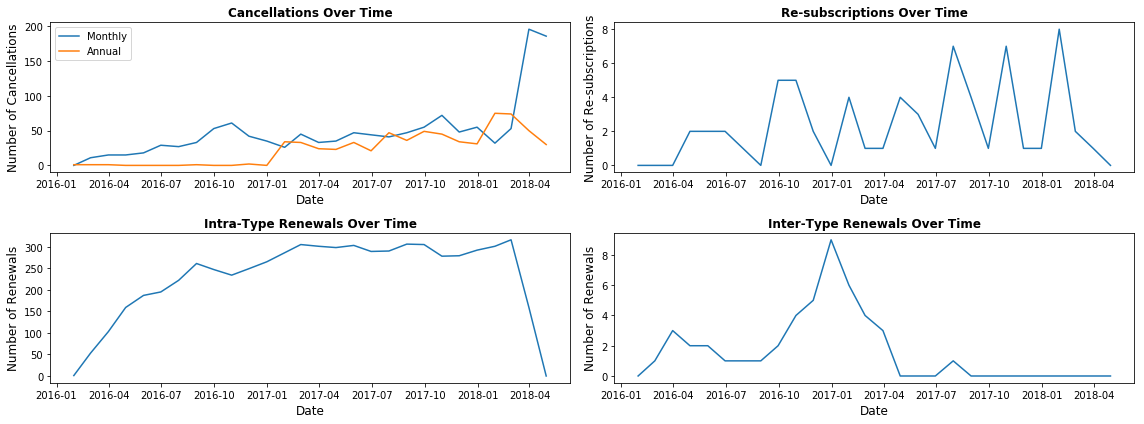

In [40]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(221)
ax.plot(df_agg_monthly.index, df_agg_monthly.num_ccl_mon, label='Monthly')
ax.plot(df_agg_monthly.index, df_agg_monthly.num_ccl_ann, label='Annual')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Cancellations')
ax.set_title('Cancellations Over Time')
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.title.set_fontsize(12)
ax.title.set_fontweight('bold')
ax.legend()

ax = fig.add_subplot(222)
ax.plot(df_agg_monthly.index, df_agg_monthly.num_rsc_a2a + \
        df_agg_monthly.num_rsc_a2m + df_agg_monthly.num_rsc_m2a + df_agg_monthly.num_rsc_m2m)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Re-subscriptions')
ax.set_title('Re-subscriptions Over Time')
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.title.set_fontsize(12)
ax.title.set_fontweight('bold')

ax = fig.add_subplot(223)
ax.plot(df_agg_monthly.index, df_agg_monthly.num_rnl_m2m + df_agg_monthly.num_rnl_a2a)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Renewals')
ax.set_title('Intra-Type Renewals Over Time')
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.title.set_fontsize(12)
ax.title.set_fontweight('bold')

ax = fig.add_subplot(224)
ax.plot(df_agg_monthly.index, df_agg_monthly.num_rnl_m2a + df_agg_monthly.num_rnl_a2m)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Renewals')
ax.set_title('Inter-Type Renewals Over Time')
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.title.set_fontsize(12)
ax.title.set_fontweight('bold')

plt.tight_layout()

In [ ]:
# Pre-process data in lesson history table:
# 1) Get the list of pupilId from subscription table
# 2) In lesson history table, filter out all records without a matched pupilId
# 3) Make sure the time period of study for the two tables are the same

# Compute the product daily usage measured in seconds, 
# using both the complete and incomplete lesson history tables:
# 1) Use the timeTaken records in the complete lesson history tables
# 2) Only use the timeTaken records for eventually completed lessons in the incomplete history tables